# Federated Learning - Régression polynomiale

### Ce fichier a pour but d'aider la visualisation du fonctionnement et des performances du Federated Learning via le Federated Averaging dans un contexte de régression polynomiale.

In [1]:
# Importation des modules de génération de données
from FLSimulator import OneDimensionalRDG, OneDimensionalLRDG

# Importation des modèles de machine learning disponibles
from FLSimulator import GDRegressor, LogisticRegressor

# Importation des modules pour créer un réseau fédéré
from FLSimulator import CentralServer, Node, FederatedNetwork

# Importation d'un module a utilisé comme fonction de base phi
from FLSimulator import polynomial_features

from random import randint

### On débute en créant un réseau fédéré simple constitué de 10 bases de données fédérés disposant de 50 à 200 observations tirés d'une distribution uniforme

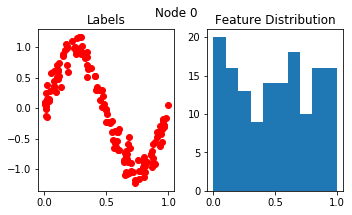

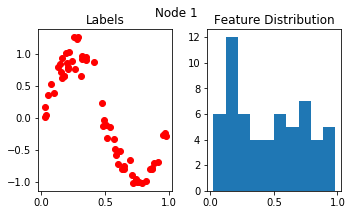

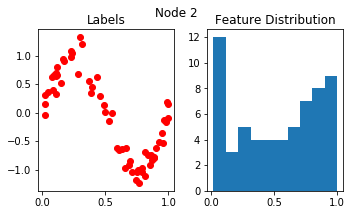

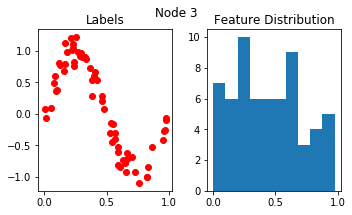

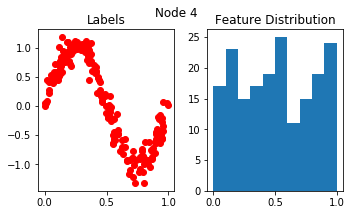

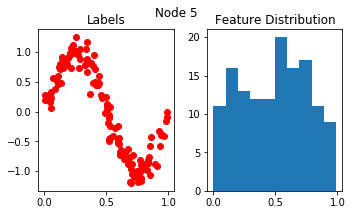

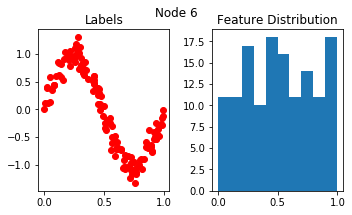

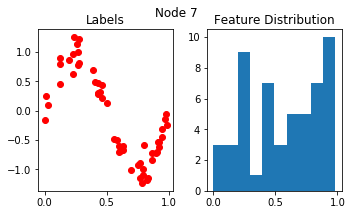

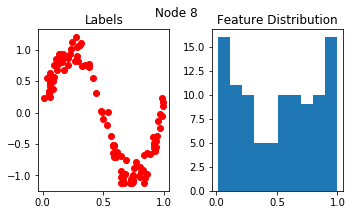

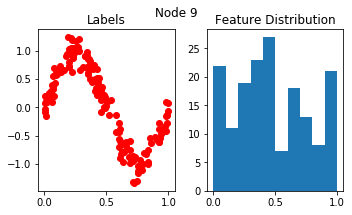

In [2]:
# 1. Création des bases de données

# 1.1 Création du DataGenerator utilisé pour générer les bases de données de chaque client (Node).
#     Les données présenteront un problème de régression simple

DG = OneDimensionalRDG(noise=0.15, label_function='sin')


# 1.2 Création des Node
nodes = []
for i in range(10):
    X, t = DG.generate_data(randint(50, 200))
    DG.distribution_and_labels(X,t, title='Node ' + str(i))
    nodes.append(Node(X, t))

In [3]:
# 2. Création du server central qui gèrera les activités de notre réseau

# 2.1 Création du modèle global qui sera entraîné et partagé par le réseau
#     Modèle de régression polynomial entraîné par GD

phi = polynomial_features(5)
polynomial_reg = GDRegressor(phi, eta0=1, learning_rate='invscaling')

# 2.2 Création du server central
#      - Il utilisera le FedAvg pour faire l'aggrégation
#      - Utilisera l'ensemble des nodes ('all') durant l'entraînement
#      - Utilisera un minibatch size de 1 (C=1) pour les entraînements de chaque Node
#      - Effectuera 200 epochs pour les entraînements de chaque Node

c_server = CentralServer(global_model=polynomial_reg, aggregation='FedAvg', node_selection='all', C=1, E=200)


In [4]:
# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

### On effectue maintenant 3 "rounds" d'entraînements et visualisons les performances du modèle global à jour entre chaque "round" en regroupant l'ensemble des bases de données dans une figure commune. Notons ici que la loss employée est celle des moindres carrés

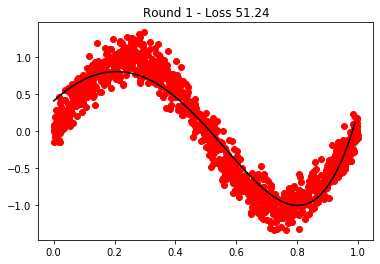

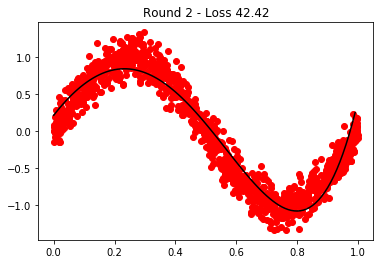

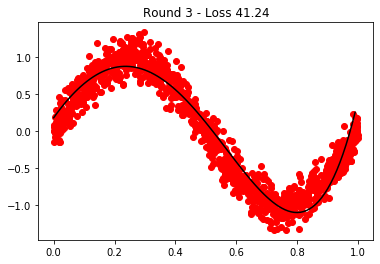

In [5]:
f_network.run_learning(nb_of_rounds=3, show_round_results=(True, 0, 1))

### L'entraînement étant coûteux en calcul et en temps, il est possible d'accélérer le processus en ne prenant qu'un échantillon de Nodes de façon aléatoire à chaque round, en ajustant le minibatch size C et le nombre d'epochs local E et évidemment le nombre de rounds.

### Reprenons donc le même context en modifiant quelques paramètres du serveur!

In [6]:
# On "reset" les poids du modèle global
polynomial_reg.reset_weights()

In [7]:
#  Modification du server central
#      - Il utilisera le FedAvg pour faire l'aggrégation
#      - Utilisera un sous ensemble aléatoire des nodes ('random') durant chaque round de l'entraînement
#      - Le sous ensemble sera constituté de 80% de l'ensemble des nodes (random_size=0.80)
#      - Utilisera un minibatch size de 2 (C=2) pour les entraînements de chaque Node
#      - Effectuera 150 epochs pour les entraînements de chaque Node

c_server = CentralServer(global_model=polynomial_reg, aggregation='FedAvg', node_selection='random', C=2, E=150, random_size=0.80)


In [8]:
# Modification du Federated Network pour accueillir pour accueillir le nouveau serveur
f_network = FederatedNetwork(c_server, nodes)

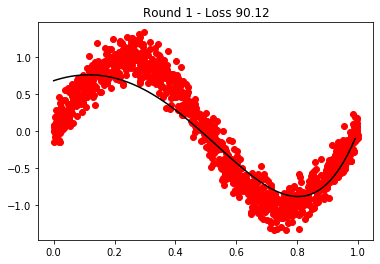

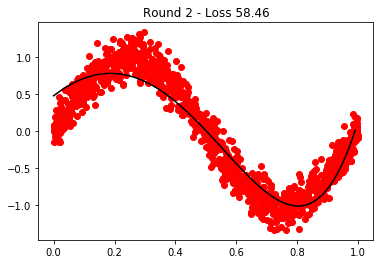

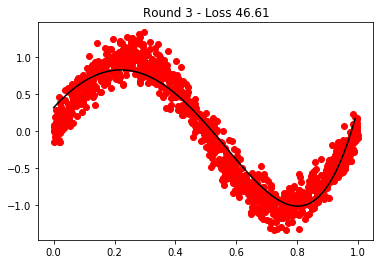

In [9]:
# On entraîne à nouveau notre réseau pendant 3 rounds
f_network.run_learning(nb_of_rounds=3, show_round_results=(True, 0, 1))

### Générons maintenant 10 nouvelles bases de données fédérées où les distributions de 3 d'entre elles seront davantage tronquées vers la gauche, 3 d'entre elles vers la droite et finalement les 4 distributions restantes seront générées à partir de loi uniforme comme précédement.

### Pour ce faire manipulons les paramètres a et b des lois bêta générant les données

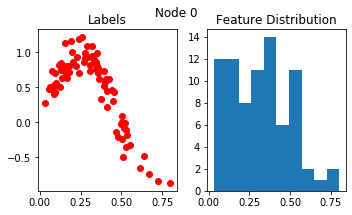

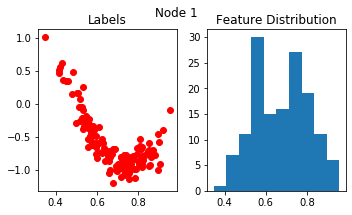

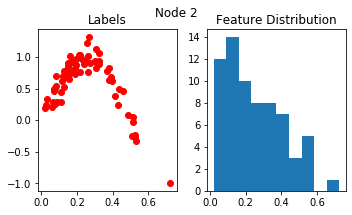

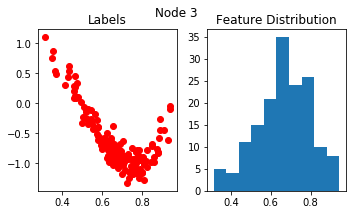

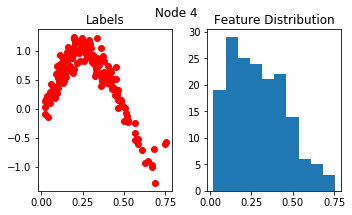

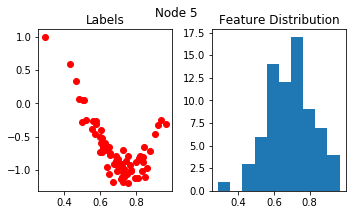

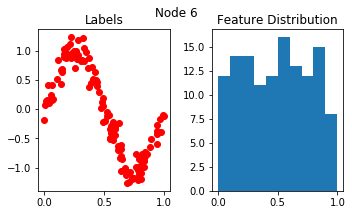

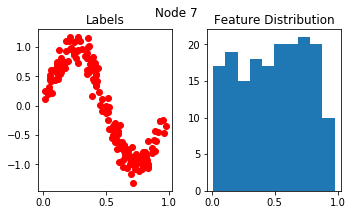

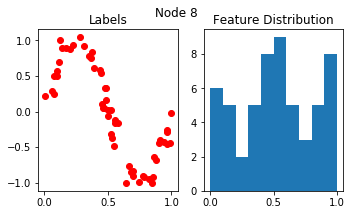

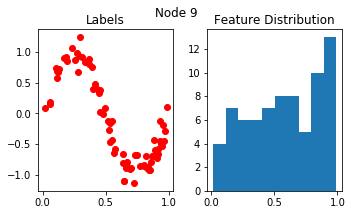

In [10]:
# 1. Création des bases de données

# 1.1 Création des DataGenerator utilisés pour générer les bases de données de chaque client (Node).
#     Les données présenteront un problème de régression simple

DG = OneDimensionalRDG(noise=0.15, label_function='sin') # uniform
DG_L = OneDimensionalRDG(noise=0.15, label_function='sin', a=2, b=5) # left skewed
DG_R = OneDimensionalRDG(noise=0.15, label_function='sin', a=8, b=4) # right skewed

# 1.2 Création des Node
nodes = []
for i in range(3):
    
    X, t = DG_L.generate_data(randint(50, 200))
    DG_L.distribution_and_labels(X,t, title='Node ' + str(2*i))
    nodes.append(Node(X, t))
    
    X, t = DG_R.generate_data(randint(50, 200))
    DG_R.distribution_and_labels(X,t, title='Node ' + str(2*i + 1))
    nodes.append(Node(X, t))
    
for i in range(4):
    
    X, t = DG.generate_data(randint(50, 200))
    DG.distribution_and_labels(X,t, title='Node ' + str(6 + i))
    nodes.append(Node(X, t))
    
    

In [11]:
# On "reset" les poids du modèle global
polynomial_reg.reset_weights()

#  Modification du server central
#      - Il utilisera le FedAvg pour faire l'aggrégation
#      - Utilisera un sous ensemble aléatoire des nodes ('random') durant chaque round de l'entraînement
#      - Le sous ensemble sera constituté de 80% de l'ensemble des nodes (random_size=0.80)
#      - Utilisera un minibatch size de 1 (C=1) pour les entraînements de chaque Node
#      - Effectuera 180 epochs pour les entraînements de chaque Node

c_server = CentralServer(global_model=polynomial_reg, aggregation='FedAvg', node_selection='random', C=1, E=180, random_size=0.80)

# Modification du Federated Network pour accueillir pour accueillir le nouveau serveur et la nouvelle list de Node
f_network = FederatedNetwork(c_server, nodes)



### On entraîne à nouveau le modèle global réseau, mais cette fois-ci on ira jusqu'à 5 rounds pour voir davantage les performances du Federated Learning

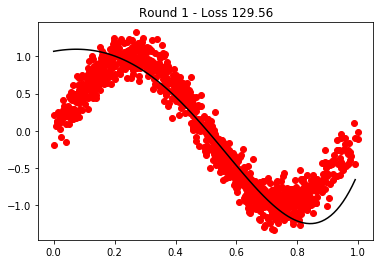

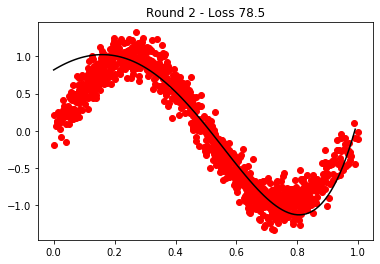

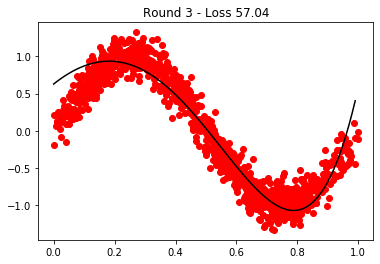

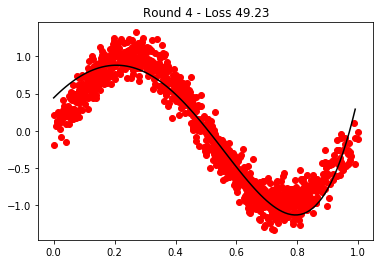

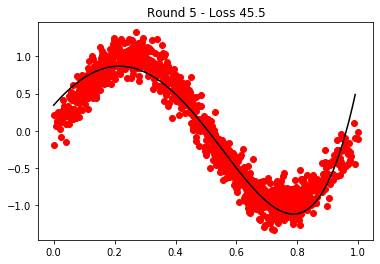

In [12]:
# On entraîne à notre réseau pendant 5 rounds
f_network.run_learning(nb_of_rounds=5, show_round_results=(True, 0, 1))

### Le bruit gaussien ajouté aux données ainsi que le nombre de points affectent la loss et il n'est donc pas possible de comparer exactement les performances de l'ancien réseau à celui-ci avec cette métrique. Toutefois, le Federated Averaging semble visiblement avoir des performances satisfaisantes même dans ce contexte.

### Finalement remplaçons une des bases de données fédérées par un ensemble de données test générés par une toute autre fonction, puis visualisons l'impact apporté au modèle global. On pourrait voir cette nouvelle base de données fédérées comme étant un échantillon d'une population où le comportement de la variable x à un impact complètement différent sur la variable y, ou également voir cette situation comme un contexte de _Data Poisonning_  

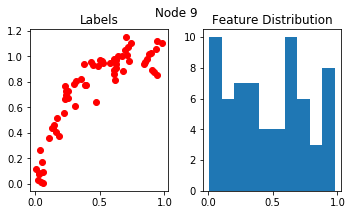

In [13]:
# On "reset" les poids du modèle global
polynomial_reg.reset_weights()

# On delete le dernier Node
nodes.pop()

# On initialise un nouveau DataGenerator
DG = OneDimensionalRDG(noise=0.10, label_function='tanh') # uniform

# On génère des points et crée un nouveau Node
X, t = DG.generate_data(randint(50, 100))
DG.distribution_and_labels(X,t, title='Node ' + str(6 + i))
nodes.append(Node(X, t))


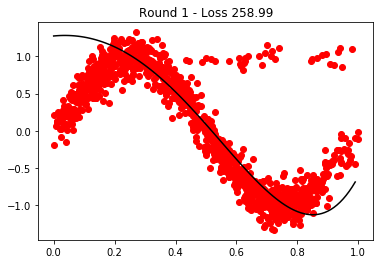

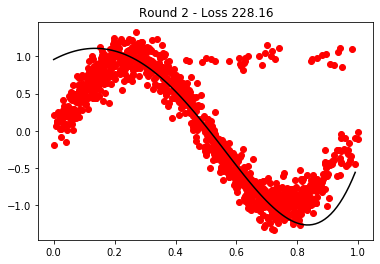

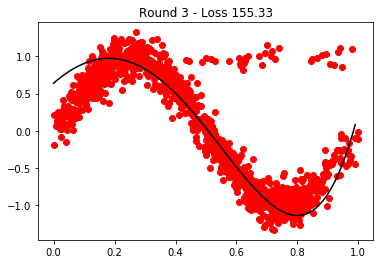

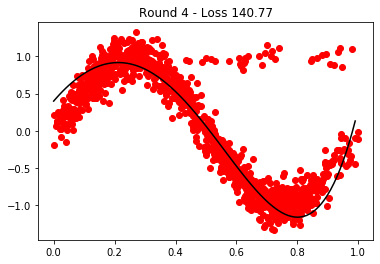

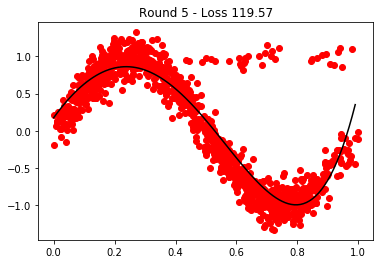

In [14]:
# On réinitialise le réseau avec le même serveur
f_network = FederatedNetwork(c_server, nodes)

# On entraîne à nouveau notre réseau pendant 5 rounds
f_network.run_learning(nb_of_rounds=5, show_round_results=(True, 0, 1))

### Il semble ici que même sur un petit ensemble de bases de données fédérées, le modèle global présente une bonne performance malgré la présence d'une base où les données présentent un comportement complètement différent.  

### On peut toutefois intrépréter cette performance autant de façon positive que négative. En effet, bien que notre modèle est performant dans la majorité des bases de données fédérées, il reste néamoins inapproporié pour faire des prédictions au sein de la base #9

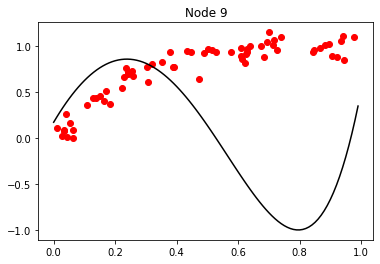

In [15]:
node = nodes[9]
node.model.w = c_server.global_model.w
node.model.plot_model(node.X, node.t, 0, 1, title='Node 9')